# Stock Prices Predictions with Machine Learning

This Notebook will contain all the data engineering, the data analysis and the modeling phases needed to predict stock prices using a deep learning model.
The stocks analyzed will be the following:
* IBM
* AAPL (Apple Inc.)
* GOOGL (Alphabet Inc.)
* AMZN (Amazon Inc.)
The model will be


In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import datetime
import pandas_datareader.data as web
import pyflux

/home/alfonso/miniconda2/envs/daSci/lib/python3.6/site-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


## Data gathering

Gatering data from two sources Alpha Vantage API

Target symbols declaration

In [2]:
ibm = 'IBM' 
aapl = 'AAPL'
googl = 'GOOGL'
amzn = 'AMZN'

### Gatering data from Alpha Vantage API

Setting dataset record start date and end date:
* start date will be the beginning of records in the AlphaVantage dataset
* end time will be today date

In [3]:
start = datetime.datetime(1999, 11, 1)
end = datetime.date.today()

Retrieving symbols data from AlphaVantage DB

In [4]:
df_av_ibm = web.DataReader(ibm, "av-daily-adjusted", start=start, end=end, api_key="os.getenv('ALPHAVANTAGE_API_KEY')")

In [5]:
df_av_aapl = web.DataReader(aapl, "av-daily-adjusted", start=start, end=end, api_key="os.getenv('ALPHAVANTAGE_API_KEY')")

In [6]:
df_av_googl = web.DataReader(googl, "av-daily-adjusted", start=start, end=end, api_key="os.getenv('ALPHAVANTAGE_API_KEY')")

In [7]:
df_av_amzn = web.DataReader(amzn, "av-daily-adjusted", start=start, end=end, api_key="os.getenv('ALPHAVANTAGE_API_KEY')")

## EDA

This section contains an exploratory data analysis on the dataset. This will allow to to have a more clean view of the source data features dynamics over time.

First off, isolate the target features:

In [9]:
df_av_ibm_ac = df_av_ibm['adjusted close']

In [10]:
df_av_aapl_ac = df_av_aapl['adjusted close']

In [11]:
df_av_googl_ac = df_av_googl['adjusted close']

In [12]:
df_av_amzn_ac = df_av_amzn['adjusted close']

Then, plot them all in one graph:

In [24]:
df_adj_close = pd.concat([df_av_ibm_ac, df_av_aapl_ac, df_av_googl_ac, df_av_amzn_ac], axis=1)
df_adj_close.columns = [ibm, aapl, googl, amzn]

In [31]:
df_adj_close.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5341 entries, 1999-11-01 to 2021-01-22
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   IBM     5341 non-null   float64
 1   AAPL    5341 non-null   float64
 2   GOOGL   4136 non-null   float64
 3   AMZN    5341 non-null   float64
dtypes: float64(4)
memory usage: 208.6+ KB


In [25]:
df_adj_close.head()

,IBM,AAPL,GOOGL,AMZN
1999-11-01,61.535122,0.597773,NaN,69.13
1999-11-02,60.301239,0.618028,NaN,66.44
1999-11-03,60.021389,0.627654,NaN,65.81
1999-11-04,58.234168,0.643981,NaN,63.06
1999-11-05,57.400979,0.680100,NaN,64.94


In [26]:
%matplotlib inline
import matplotlib.pyplot as plt

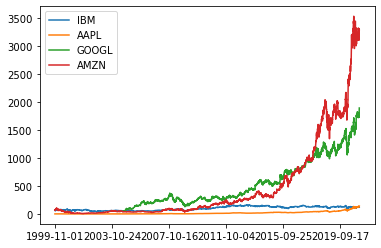

In [27]:
df_adj_close.plot(legend=True)

Google data starts in:

In [29]:
df_av_googl_ac.first_valid_index()

'2004-08-19'

so every value before this date could be conveniently set to 0 or other values. Let's start with 0:

In [33]:
df_adj_close.fillna(0, inplace=True)

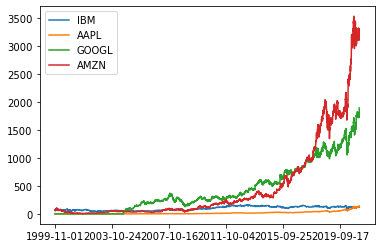

In [34]:
df_adj_close.plot(legend=True)

### SMA

For each of the symbols, a simple moving average could be calculated, in order to do so 4 new dataframe will be created, containing the moving average of each symbol.

first setting window size:

In [63]:
ws = 7

In [64]:
ibm_ma = df_av_ibm['adjusted close'].rolling(window=ws).mean()
df_av_ibm['adjusted close moving average'] = ibm_ma

In [65]:
df_av_ibm.head()

,open,high,low,close,adjusted close,volume,dividend amount,split coefficient,adjusted close moving average
1999-11-01,98.50,98.81,96.37,96.75,61.535122,9551800,0.0,1.0,NaN
1999-11-02,96.75,96.81,93.69,94.81,60.301239,11105400,0.0,1.0,NaN
1999-11-03,95.87,95.94,93.50,94.37,60.021389,10369100,0.0,1.0,NaN
1999-11-04,94.44,94.44,90.00,91.56,58.234168,16697600,0.0,1.0,NaN
1999-11-05,92.75,92.94,90.19,90.25,57.400979,13737600,0.0,1.0,NaN


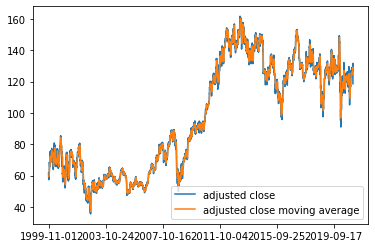

In [66]:
df_av_ibm['adjusted close'].plot(legend=True)
df_av_ibm['adjusted close moving average'].plot(legend=True)

In [45]:
ibm_ma.describe()

count    5335.000000
mean       97.515987
std        34.626072
min        37.188993
25%        63.238077
50%        92.002136
75%       129.347802
max       160.227180
Name: adjusted close, dtype: float64

Computing metrics on the moving average

In [50]:
from sklearn.metrics import mean_squared_error